

**3rd Assignment - Extreme Driving Detection**

---

Nikos Stamatis

MSc Student  

Graduate Programme in Data Science and Machine Learning  

SN: 03400115
 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

from scipy.spatial import distance

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
from google.colab import drive
import os
import pickle
 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv("/content/drive/My Drive/all_LAT_uns.csv", delim_whitespace=False)
data = df.copy()
data

,NewAccelX,NewAccelY,NewAccelZ,NewRotRateX,NewRotRateY,NewRotRateZ,locationSpeed
0,0.001,-0.002,-0.007,0.002,-0.001,0.000,0.0
1,0.007,0.000,0.011,-0.001,0.001,0.000,0.0
2,0.008,0.004,0.015,0.000,0.000,-0.001,0.0
3,0.008,0.002,0.004,0.002,-0.001,-0.001,0.0
4,0.009,0.001,0.026,-0.002,-0.001,0.002,0.0
...,...,...,...,...,...,...,...
103886,0.009,-0.001,-0.018,-0.022,0.011,0.004,0.0
103887,-0.014,-0.067,-0.021,0.058,-0.048,-0.001,0.0
103888,-0.005,0.022,-0.006,-0.003,0.022,0.001,0.0
103889,0.022,-0.009,-0.003,-0.008,-0.006,0.003,0.0


# Introduction

The purpose of this assignment is to detect extreme vehicle turning movements, based on data obtained from the driver's smartphone sensors. The dataset contains 103891 entries and consists of 7 different features:

The features *NewAccelX*, *NewAccelY* and *NewAccelZ* describe the accelerations on the x, y, and z axes respectively, the y axis being the direction of the vehicle's motion.

The features *NewRotRateX*,	*NewRotRateY*	and *NewRotRateZ* correspond to the pitch, roll and yaw, measuring the angular acceleration with respect to the x, y, and z axes respectively.  

There is an additional feature *locationSpeed* which probably  measures the vehicle's speed. 

To approach the problem, we apply three outlier detecting algorithms, the DBSCAN, the Elliptic Envelope and the Local Outlier Factor methods. 



## DBSCAN

The DBSCAN algorithm is a popular clustering algorithm that can be used for outlier detection. It has the advantage of not having to specify in advance the number of clusters, useful when the researcher does not possess a prior knowledge about them. However, it does include two parameters which must be chosen carefully, namely the MinPts and EPS.  A third and more subtle parameter is the underlying metric. 

The main concept of the algorithm is to partition the data points into three different sets: The *core points*, the *border points* and the *noise points*. 
 A point $x$ is a *core point* when the ball $B(x, \text{EPS})$ contains at least MinPts points. A point $x$ is a *border point* when the ball $B(x, \text{EPS})$ contains less than MinPts, but at least one core point. All the remaining points are *noise points*.

The output of the algorithm is the clusters it found, plus another "cluster" which contains the noise points. We expect to find our outliers in the latter group. Note however that collective outliers might themselves form a regular cluster, for example all sudden turning movements may exhibit similar characteristics among them. For this reason,  we initially treat all   clusters as candidates of containing   extreme movements of the same type, and establish whether this is indeed the case by examining their characteristics separately. 

In our setting, we picked the MinPts according to the heuristic rule $\text{MinPts} = 2D = 14$ and $\text{EPS}=\sqrt{0.5}$. For our metric we chose the Mahalanobis distance, induced by the inner product $\langle x, y\rangle = \sqrt{x'A^{-1}y}$, where $A$ is a symmetric and positive definite matrix. By picking  a diagonal matrix $A=\text{diag}(a_1, \ldots, a_7)$, the Mahalanobis distance between two points is then 

$$d_A(x, y) = \|x-y\|_A  = \sqrt{\sum_{i=1}^7 \frac{1}{a_i}|x_i-y_i|^2}.$$

The reasoning behind our choice is the following: The DBSCAN algorithm will detect outliers, some of which will be turning movements, but most will not. By allowing the  $a_i$  coefficients to act as weights, we can give a larger weight to features that we expect to be associated with turning movements, namely NewAccelX and NewRotRateZ. 

Lets see a very simple example: Consider three points in $\mathbb{R}^2$, $x=(0,0)$, $y=(1,0)$ and $z=(0,1)$, and the Mahalanobis distance induced by $A=\text{diag}(a_1, a_2)$. Suppose that we wish to define $A$ in such a way that two points are far apart when mostly their second coordinates are far apart. Then 
$$ \|x-y\|_A^2  = \frac{1}{a_1} \ \ \text{and} \ \|x-z\|_A^2  = \frac{1}{a_2}, $$
so we need to pick $\frac{1}{a_2}>\frac{1}{a_1}$, or equivalently, $a_2<a_1$. 





In [ ]:
clustering4 = DBSCAN(eps=np.sqrt(0.5), min_samples=14, metric='mahalanobis', 
                    metric_params={'V': np.diag([1/7, 1, 1, 1, 1, 1/8, 1])}).fit(data)
DBSCAN_la4 = clustering4.labels_
unique4, counts4 = np.unique(DBSCAN_la4, return_counts=True)
dict(zip(unique4, counts4)) # 687

{-1: 687, 0: 103204}

Recall that DBSCAN assigns the label -1 to the noise points and  the labels $0, 1, 2, \ldots$ to the rest of the clusters.

In [ ]:
maha = data.copy()
maha2 = data.copy()
maha2['DBSCAN'] = DBSCAN_la4
maha_abs = np.abs(maha)
maha_abs['DBSCAN'] = DBSCAN_la4

The noise points have indeed larger than average values for the two most prominent turning movement features:

In [ ]:
maha_abs.groupby('DBSCAN', as_index=False)['NewAccelX'].mean()

,DBSCAN,NewAccelX
0,-1,0.167429
1,0,0.034611


In [ ]:
maha_abs.groupby('DBSCAN', as_index=False)['NewRotRateZ'].mean()

,DBSCAN,NewRotRateZ
0,-1,1.020015
1,0,0.031767


We now remove some entries which do not correspond to such extreme turning movements using a statistical criterion. First, we compute the means and standard deviations for NewAccelX and NewRotRateZ in the original dataset.

In [ ]:
print('Statistical measures for the NewAccelX feature: mean = {:0.5f} with std = {:0.5f}.\nStatistical measures for the NewRotRateZ feature: mean = {:0.5f} with std = {:0.5f}.'
  .format( abs(data['NewAccelX']).mean(), abs(data['NewAccelX']).std(), abs(data['NewRotRateZ']).mean(), abs(data['NewRotRateZ']).std()))

Statistical measures for the NewAccelX feature: mean = 0.03549 with std = 0.04597.
Statistical measures for the NewRotRateZ feature: mean = 0.03830 with std = 0.14153.


Then, we discard the entries which do not fall too far from the mean:

In [ ]:
dbs2 = maha_abs[maha_abs['DBSCAN'] == -1]
print('Initial number of the DBSCAN outliers: {}.'.format(dbs2.shape[0])) # 687
maha['DBSCAN'] = DBSCAN_la4
for i in range(len(DBSCAN_la4)):
  if (abs(maha['NewRotRateZ'][i]) < 0.0383 + 0.14153) & (abs(maha['NewAccelX'][i]) < 0.03549 + 0.04597): maha.at[i, 'DBSCAN'] = 1

test = maha[maha['DBSCAN'] == -1]   
dbscan = maha[maha['DBSCAN'] == -1]  
print('Number of the DBSCAN outliers after filtering in the turning movements: {}.'.format(dbscan.shape[0])) # 649

Initial number of the DBSCAN outliers: 687.
Number of the DBSCAN outliers after filtering in the turning movements: 649.


As we can see, only a handful of entries (38 out of 687, namely a 5.5% of the noise points) were removed. We can see this as an indication of success for the choice of the Mahalanobis distance, as the DBSCAN algorithm not only detected outliers, but most of them were corresponding to some type of turning movement.

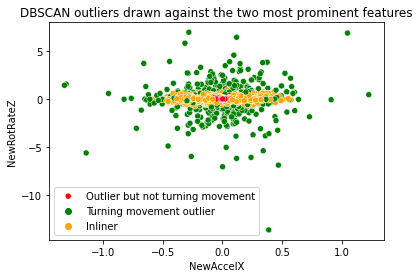

In [ ]:
g = sns.scatterplot(x="NewAccelX", y="NewRotRateZ", hue="DBSCAN",
              data=maha, palette=['green','orange', 'red'], legend='full')
plt.title('DBSCAN outliers drawn against the two most prominent features')
plt.legend(loc='lower left', labels=['Outlier but not turning movement',   'Turning movement outlier', 'Inliner'])

## Elliptic Envelope

The Elliptic Elnvelope is another method which can be used for outlier detection. Its main assumption is that the data points $x=(x_1,\ldots, x_7)$ follow a distribution of the form $$f(x)=\frac{1}{|\Sigma|}g((x-\mu)'\Sigma^{-1}(x-\mu))$$ for some strictly decreasing real function $g$, and a positive definite and symmetric matrix $\Sigma$. For example, a multivariate normal distribution is special case of it. 

It then finds the regions on which most of the measure of $f$ is concentrated, and considers as an outlier anything that is not contained in it. Because of the similarity of $f$ with the pdf of the multivariate normal, the decision regions are often ellipses, caused by the presence of the Mahalanobis distance $(x-\mu)'\Sigma^{-1}(x-\mu)$, thus the name "Elliptic Envelope".

To implement the method, we first need to determine the   *contamination* hyperparameter, which denotes the fraction of the data points that are considered to be outliers. Given that DBSCAN initially fount around 700 outliers, we chose a fraction of 0.02 so as to broaden up our search.

In [ ]:
cov = EllipticEnvelope(random_state=42, contamination=0.02).fit(data)

envelope_la = cov.predict(data)
unique_env, counts_env = np.unique(envelope_la, return_counts=True)
dict(zip(unique_env, counts_env)) # 2078

{-1: 2078, 1: 101813}

Like before, we weed out the non-turning movements. 

In [ ]:
maha['Envelope'] = envelope_la
#maha2['Envelope'] = envelope_la
print('Initial number of the Elliptic Envelope outliers: {}.'.format(maha[maha['Envelope'] == -1].shape[0])) # 2078
#print(maha[maha['Envelope'] == -1].shape)
for i in range(len(envelope_la)):
  if (abs(maha['NewRotRateZ'][i]) < 0.0383 + 0.14153) & (abs(maha['NewAccelX'][i]) < 0.03549 + 0.04597): maha.at[i, 'Envelope'] = 2

print('Number of the Elliptic Envelope outliers after filtering in the turning movements: {}.'
  .format(maha[maha['Envelope'] == -1].shape[0])) # 1840
 
print('Number of DBSCAN outliers: {}'.format(maha[(maha['DBSCAN'] == -1)].shape[0])) # 649
print('Number of common DBSCAN and Elliptic Envelope outliers: {}'.format(maha[(maha['DBSCAN'] == -1) & (maha['Envelope'] == -1)].shape[0])) #629

Initial number of the Elliptic Envelope outliers: 2078.
Number of the Elliptic Envelope outliers after filtering in the turning movements: 1840.
Number of DBSCAN outliers: 649
Number of common DBSCAN and Elliptic Envelope outliers: 629


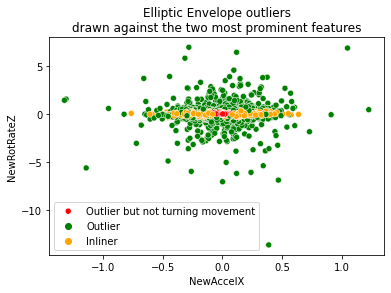

In [ ]:
g = sns.scatterplot(x="NewAccelX", y="NewRotRateZ", hue="Envelope",
              data=maha, palette=['green','orange', 'red'], legend='full')
plt.title('Elliptic Envelope outliers\ndrawn against the two most prominent features')
plt.legend(loc='lower left', labels=['Outlier but not turning movement', 'Outlier', 'Inliner'])

## Local Outlier  Factor

The Local Outlier Factor (LOF) is a method specifically designed to detect outliers. It is very similar to DBSCAN with two main differences: 1) It also searches for local outliers, namely points that although may not seem like outliers when looking at the dataset globally, they exhibit outlier behavior when examined locally.  2) Rather than classifying each point as outlier or inliner, it assigns a value on it, called *outlier factor* which describes the degree on which the respective point is an ourlier. 

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
LOF_la = clf.fit_predict(data)
unique_lof, counts_lof = np.unique(LOF_la, return_counts=True)
dict(zip(unique_lof, counts_lof)) # 5195

{-1: 5195, 1: 98696}

In [ ]:
maha['LOF'] = LOF_la
#maha2['Envelope'] = envelope_la
print('Initial number of the LOF outliers: {}.'.format(maha[maha['LOF'] == -1].shape[0])) # 5195
#print(maha[maha['Envelope'] == -1].shape)
for i in range(len(envelope_la)):
  if (abs(maha['NewRotRateZ'][i]) < 0.0383 + 0.14153) & (abs(maha['NewAccelX'][i]) < 0.03549 + 0.04597): maha.at[i, 'LOF'] = 2

print('Number of the LOF outliers after filtering in the turning movements: {}.'
  .format(maha[maha['LOF'] == -1].shape[0])) # 2697
 
print('Number of DBSCAN outliers: {}'.format(maha[(maha['DBSCAN'] == -1)].shape[0]))
print('Number of common DBSCAN and Elliptic Envelope outliers: {}'.format(maha[(maha['DBSCAN'] == -1) & (maha['Envelope'] == -1)].shape[0]))
print('Number of common DBSCAN,  Elliptic Envelope and LOF outliers: {}'.format(maha[(maha['DBSCAN'] == -1) & (maha['Envelope'] == -1) & (maha['LOF'] == -1)].shape[0]))

Initial number of the LOF outliers: 5195.
Number of the LOF outliers after filtering in the turning movements: 2697.
Number of DBSCAN outliers: 649
Number of common DBSCAN and Elliptic Envelope outliers: 629
Number of common DBSCAN,  Elliptic Envelope and LOF outliers: 338


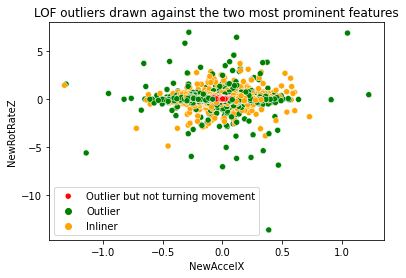

In [ ]:
g = sns.scatterplot(x="NewAccelX", y="NewRotRateZ", hue="LOF",
              data=maha, palette=['green','orange', 'red'], legend='full')
plt.title('LOF outliers drawn against the two most prominent features')
plt.legend(loc='lower left', labels=['Outlier but not turning movement', 'Outlier', 'Inliner'])

To compile the final list of our outliers, several voting schemes could be used  in order to combine the results from all the classifiers in a weighted manner. However, given the nature of the problem and the total number of outlier each algorithm detected, we decided to classify a data point as an outlier only when all three algortihms agreed on it being one.  

In [ ]:
final_outliers = maha[(maha['DBSCAN'] == -1) & (maha['Envelope'] == -1) & (maha['LOF'] == -1)]
final_outliers = final_outliers[['NewAccelX',	'NewAccelY',	'NewAccelZ',	'NewRotRateX',	
                                'NewRotRateY',	'NewRotRateZ',	'locationSpeed']]
final_outliers

,NewAccelX,NewAccelY,NewAccelZ,NewRotRateX,NewRotRateY,NewRotRateZ,locationSpeed
219,0.387,1.033,0.420,2.796,-12.628,-13.615,6.78
497,0.374,-2.163,0.409,0.854,-0.908,3.835,15.52
502,0.023,0.016,-0.035,0.143,0.319,3.476,5.74
514,0.462,-0.871,-0.756,5.250,-0.086,-3.246,0.00
632,-0.090,0.024,0.082,-1.464,-0.437,0.161,3.41
...,...,...,...,...,...,...,...
103749,0.364,0.322,0.673,0.288,0.538,-0.030,7.74
103774,-0.045,-0.192,0.094,1.187,-0.388,-0.635,11.42
103786,-0.297,-0.497,-0.083,0.535,-0.108,-0.173,12.26
103796,-0.953,-0.320,0.263,-0.263,-1.216,0.586,9.69


In [ ]:
final_outliers.to_csv('outliers.csv') 
files.download('outliers.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>